In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'USD'
share_name = 'PXT.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,204,-41,163,17,34,181,14,281,61,...,0,0,0,236,42,463,40,-30,136.14,2014-11-09
1,2014-12-31,144,-39,105,-126,39,74,11,187,74,...,0,0,0,183,35,374,121,-83,136.14,2015-03-01
2,2015-03-31,124,-28,96,-15,33,68,8,172,74,...,0,0,0,162,40,362,-4,-27,151.83,2015-05-05
3,2015-06-30,144,-31,112,2,104,45,8,212,74,...,0,0,0,122,0,289,62,-37,151.83,2015-08-04
4,2015-09-30,114,-26,89,-27,109,21,9,204,74,...,0,0,0,141,0,265,94,-38,151.83,2015-11-09


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-09-30,2023-11-09,106.29,315,-50,265,120,35,143,3,...,0,2264,0,0,1,298,0,390,87,-156
37,2023-12-31,2024-02-29,103.81,310,-72,238,134,140,106,4,...,0,2415,252,0,1,258,90,460,194,-91
38,2024-03-31,2024-05-06,102.91,283,-59,224,60,61,146,8,...,0,2355,214,0,6,220,60,383,97,-98
39,2024-06-30,2024-07-29,102.27,305,-63,242,4,119,100,10,...,0,2324,247,0,5,247,50,398,222,-97
40,2024-09-30,2024-11-04,100.89,257,-65,192,66,147,49,10,...,0,2290,206,0,5,210,30,347,181,-68


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-09,106.29,315,-50,265,120,35,143,3,...,2264,0,0,1,298,0,390,87,-156,1.341033
37,2023-12-31,2024-02-29,103.81,310,-72,238,134,140,106,4,...,2415,252,0,1,258,90,460,194,-91,1.361617
38,2024-03-31,2024-05-06,102.91,283,-59,224,60,61,146,8,...,2355,214,0,6,220,60,383,97,-98,1.347550
39,2024-06-30,2024-07-29,102.27,305,-63,242,4,119,100,10,...,2324,247,0,5,247,50,398,222,-97,1.367756
40,2024-09-30,2024-11-04,100.89,257,-65,192,66,147,49,10,...,2290,206,0,5,210,30,347,181,-68,1.364419


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-09,106.29,422.425371,-67.051646,355.373725,160.923951,46.936152,191.767708,4.023099,...,3036.098538,0.000000,0.0,1.341033,399.627811,0.000000,523.002840,116.669864,-209.201136,1.341033
37,2023-12-31,2024-02-29,103.81,422.101391,-98.036452,324.064939,182.456730,190.626434,144.331443,5.446470,...,3288.305995,343.127582,0.0,1.361617,351.297286,122.545565,626.343999,264.153773,-123.907182,1.361617
38,2024-03-31,2024-05-06,102.91,381.356739,-79.505468,301.851270,80.853019,82.200569,196.742346,10.780403,...,3173.480988,288.375767,0.0,8.085302,296.461069,80.853019,516.111770,130.712380,-132.059931,1.347550
39,2024-06-30,2024-07-29,102.27,417.165626,-86.168637,330.996988,5.471025,162.762982,136.775615,13.677562,...,3178.665293,337.835769,0.0,6.838781,337.835769,68.387808,544.366948,303.641865,-132.672347,1.367756
40,2024-09-30,2024-11-04,100.89,350.655618,-88.687219,261.968399,90.051637,200.569556,66.856519,13.644187,...,3124.518930,281.070262,0.0,6.822094,286.527937,40.932562,473.453305,246.959793,-92.780475,1.364419


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-11-10,7.931408,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.63457,0.36543,0.0,0.0,0.0,0.0,0.79902,0.083333,0.0,0.0
1,2014-11-17,8.271209,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.63457,0.36543,0.0,0.0,0.0,0.0,0.79902,0.083333,0.0,0.0
2,2014-11-24,6.663379,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.63457,0.36543,0.0,0.0,0.0,0.0,0.79902,0.083333,0.0,0.0
3,2014-12-01,6.298716,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.63457,0.36543,0.0,0.0,0.0,0.0,0.79902,0.083333,0.0,0.0
4,2014-12-08,5.262743,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.63457,0.36543,0.0,0.0,0.0,0.0,0.79902,0.083333,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-11-10,7.931408,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.0,0.79902,0.083333,0.0,0.0,inf,1.234643,inf,inf,inf
1,2014-11-17,8.271209,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.0,0.79902,0.083333,0.0,0.0,inf,1.287538,inf,inf,inf
2,2014-11-24,6.663379,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.0,0.79902,0.083333,0.0,0.0,inf,1.037255,inf,inf,inf
3,2014-12-01,6.298716,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.0,0.79902,0.083333,0.0,0.0,inf,0.980490,inf,inf,inf
4,2014-12-08,5.262743,2014-09-30,221.905845,0.0,6.424049,136.14,0.0,0.0,36.984307,...,0.0,0.79902,0.083333,0.0,0.0,inf,0.819225,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

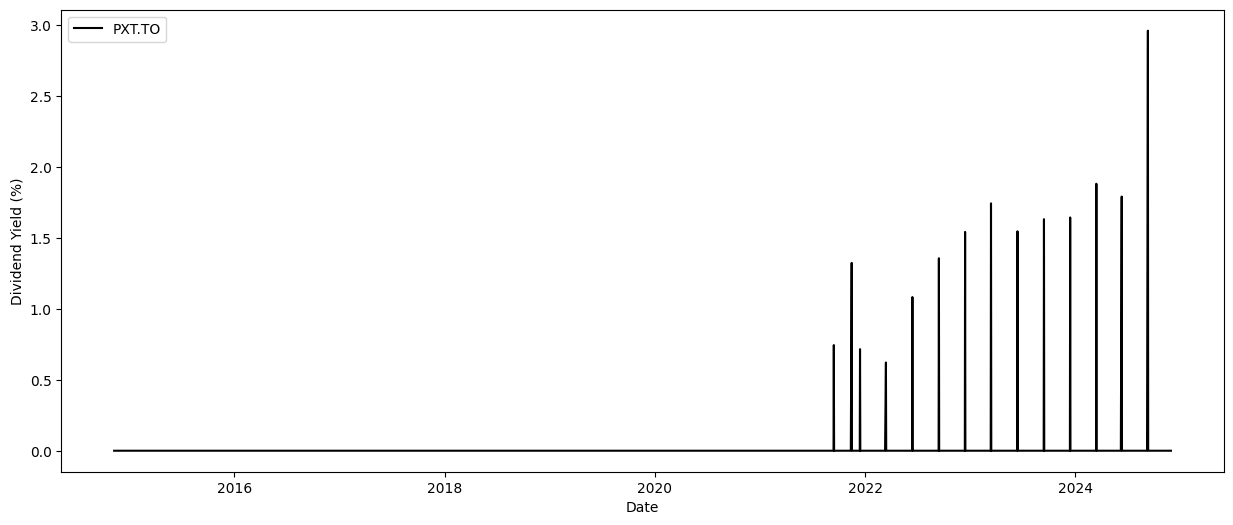

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.200814
share_price      1.000000
Name: share_price, dtype: float64


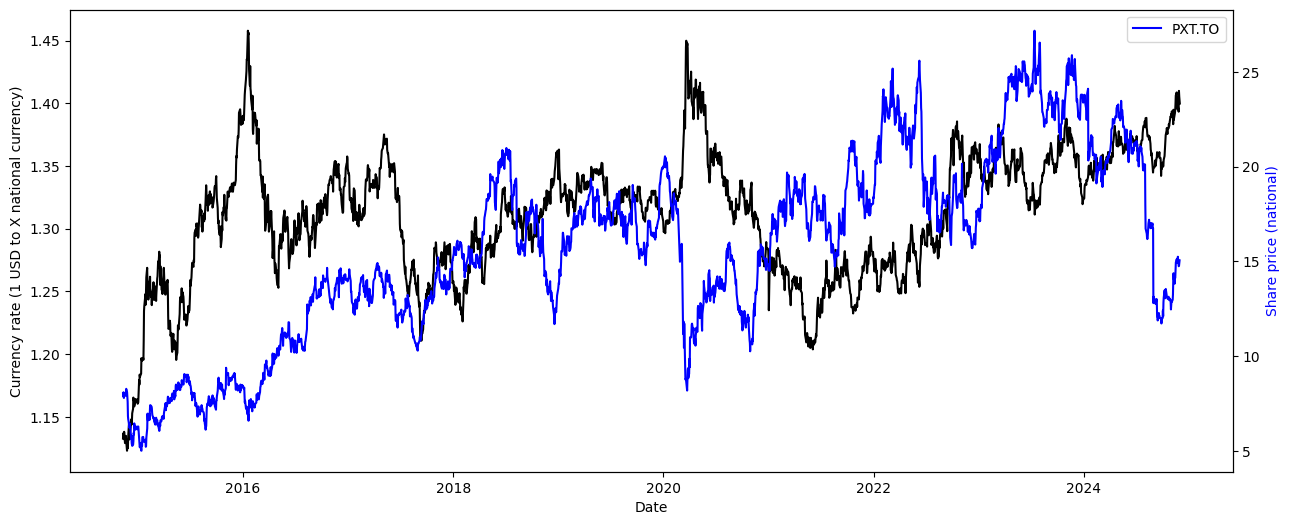

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

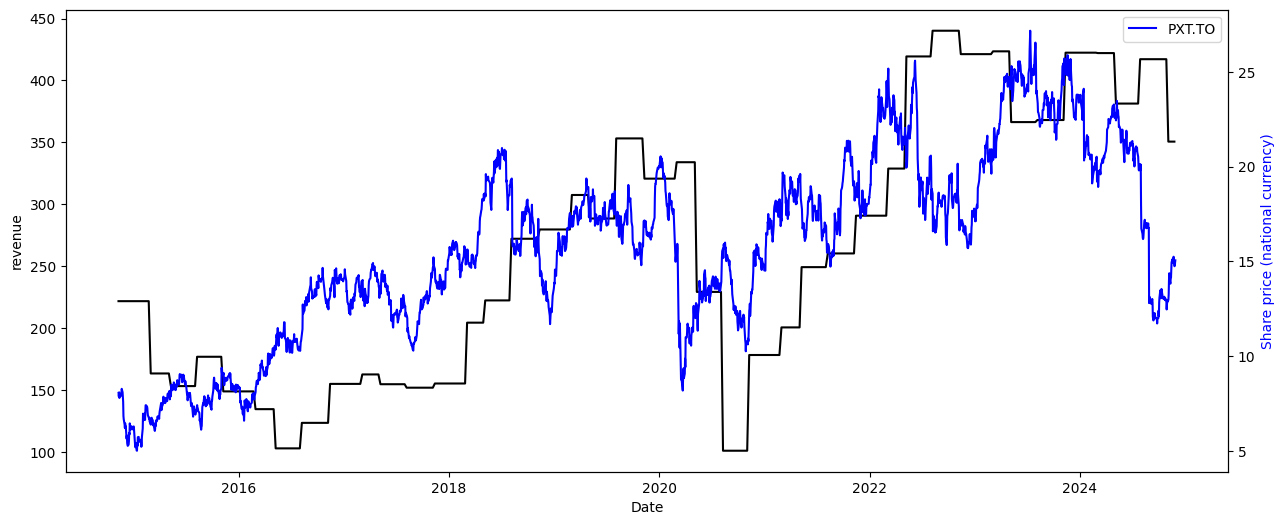

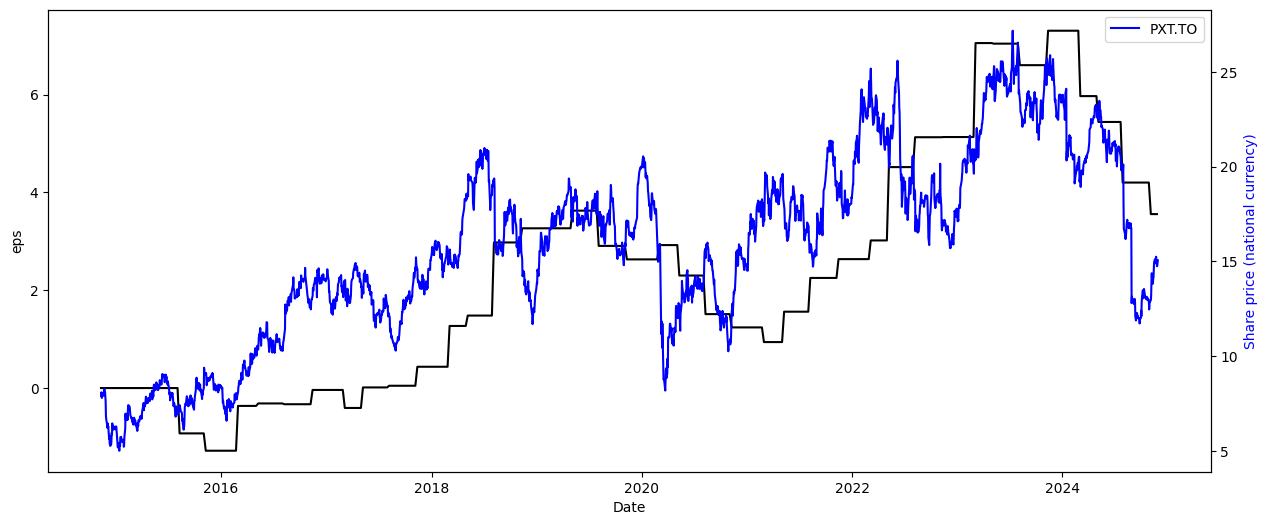

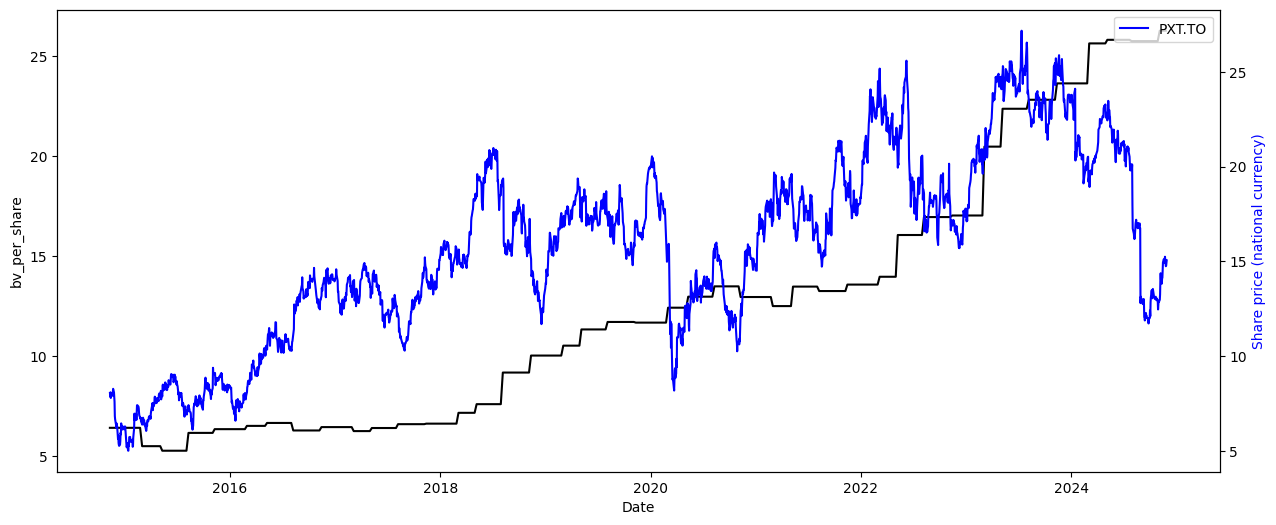

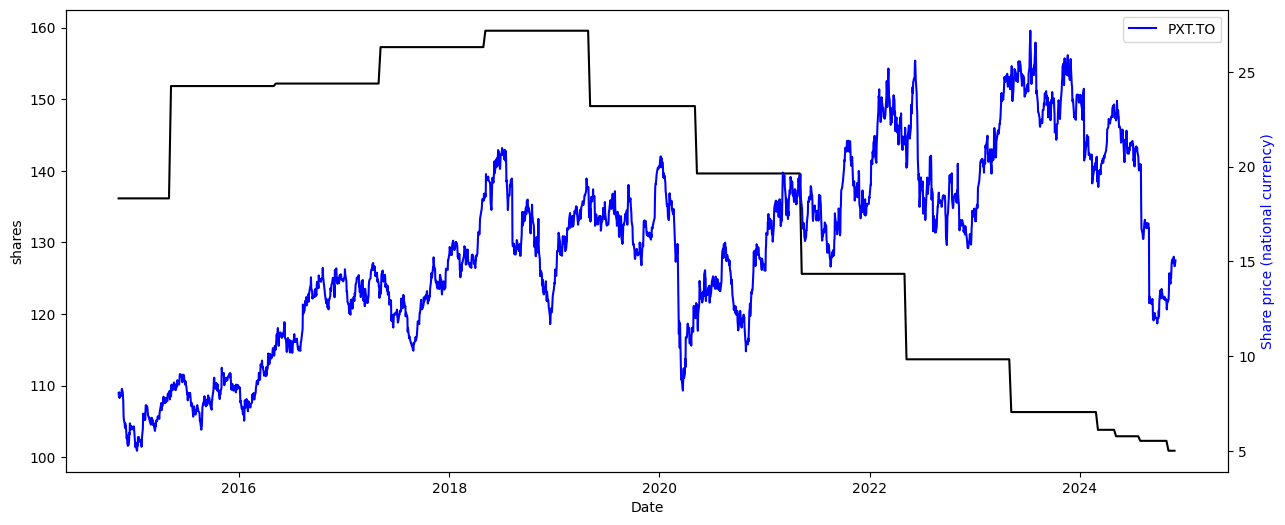

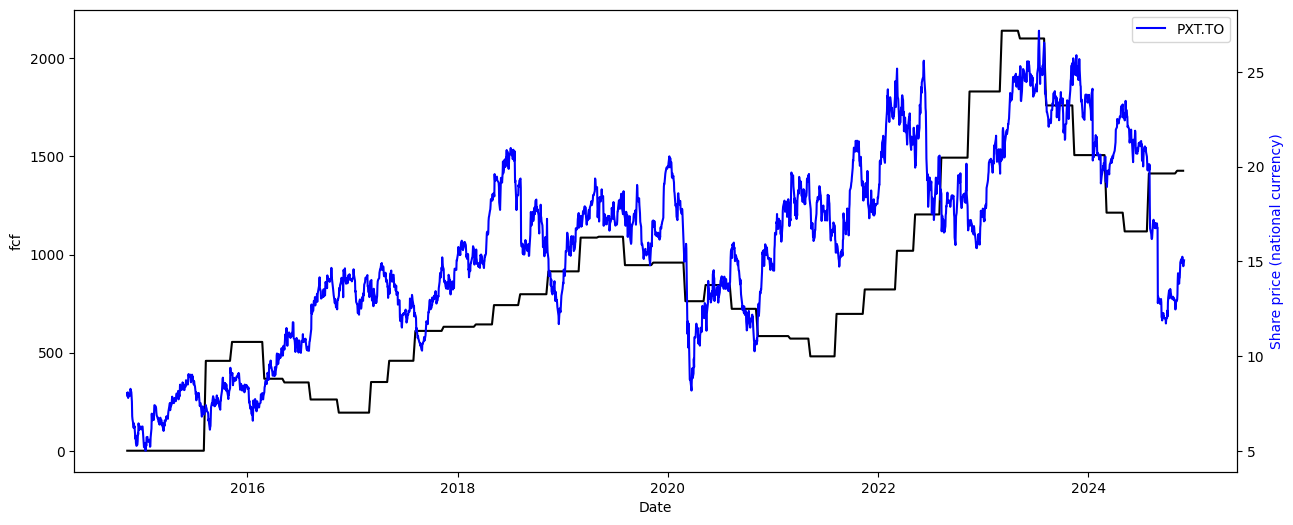

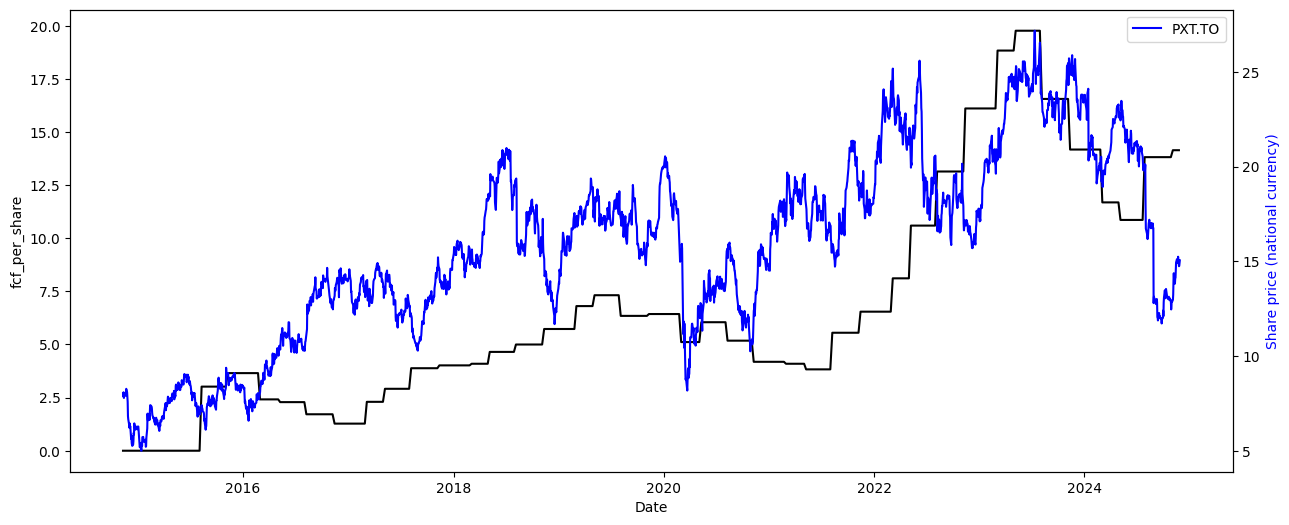

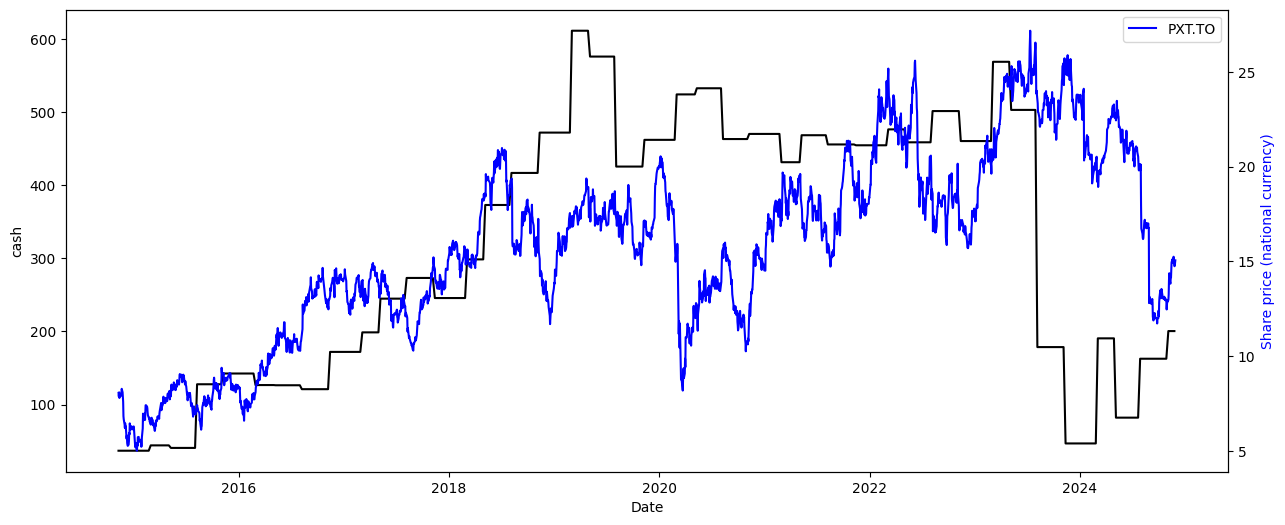

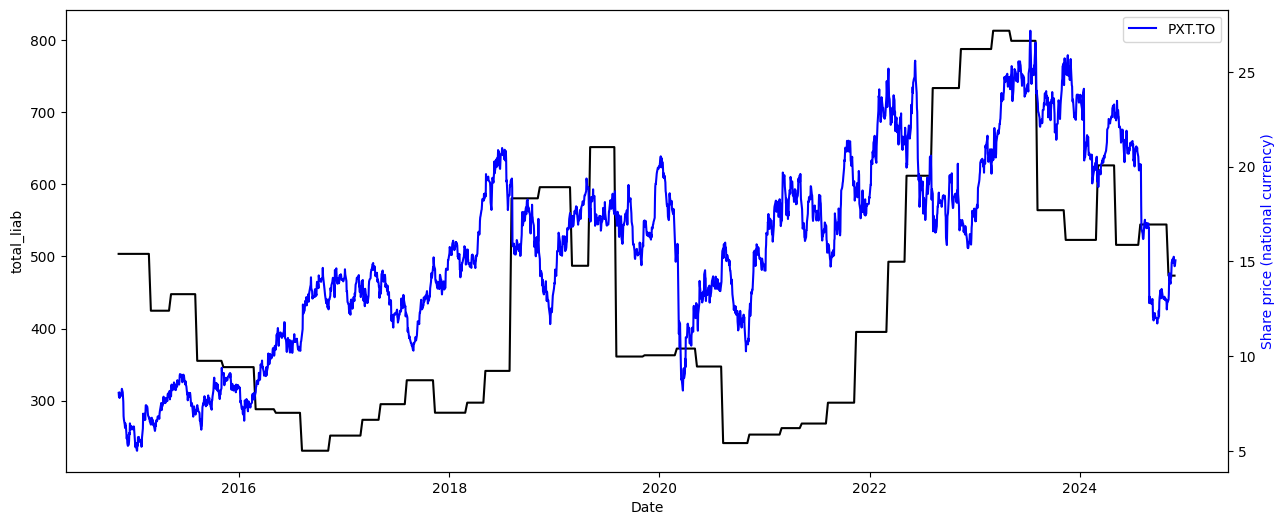

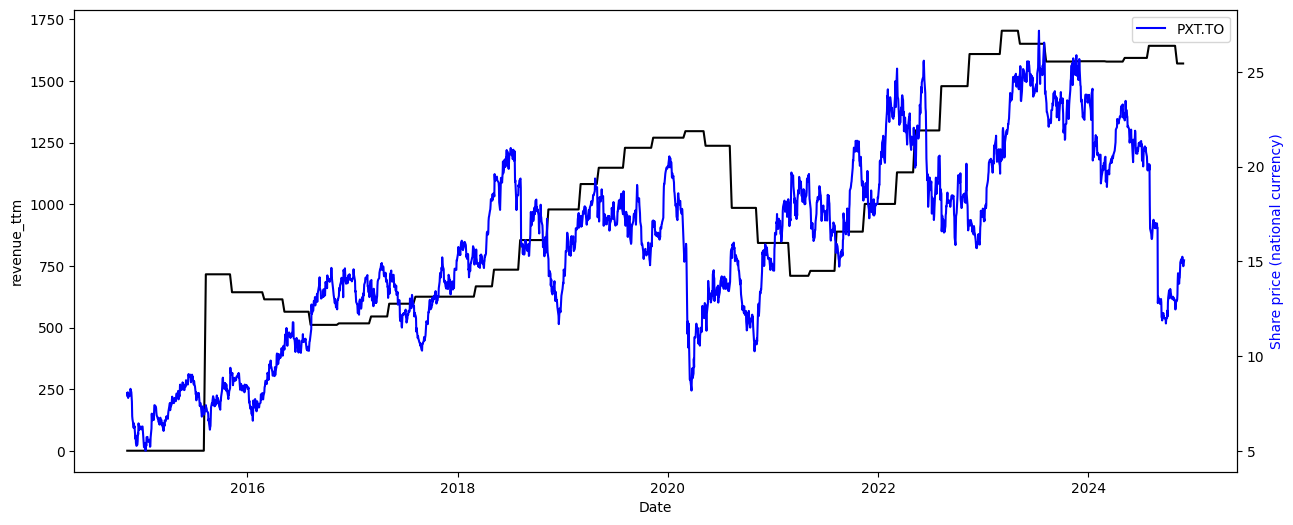

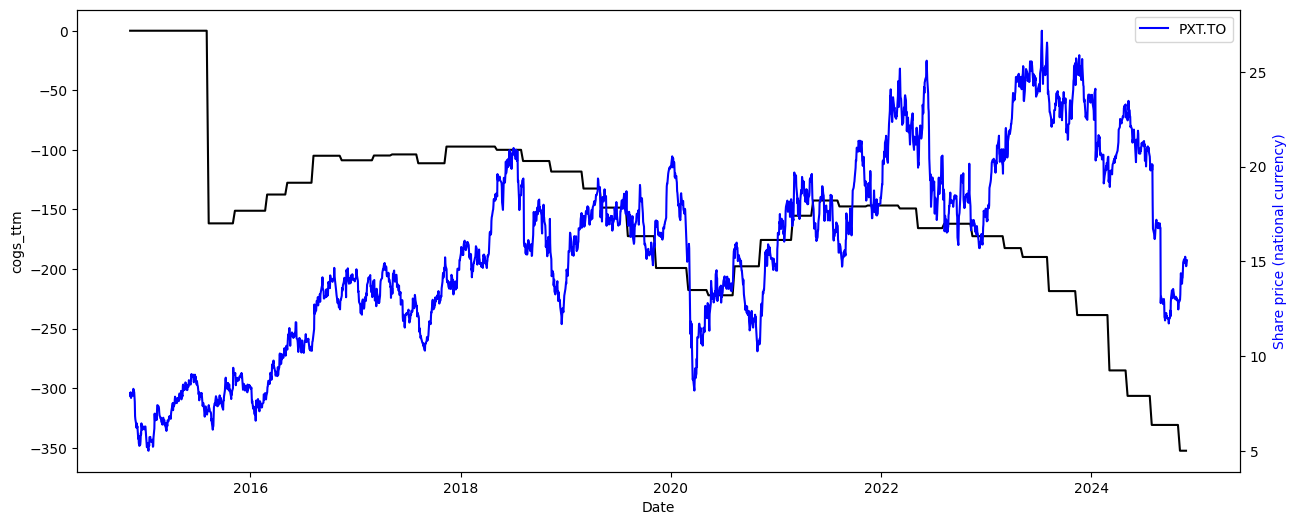

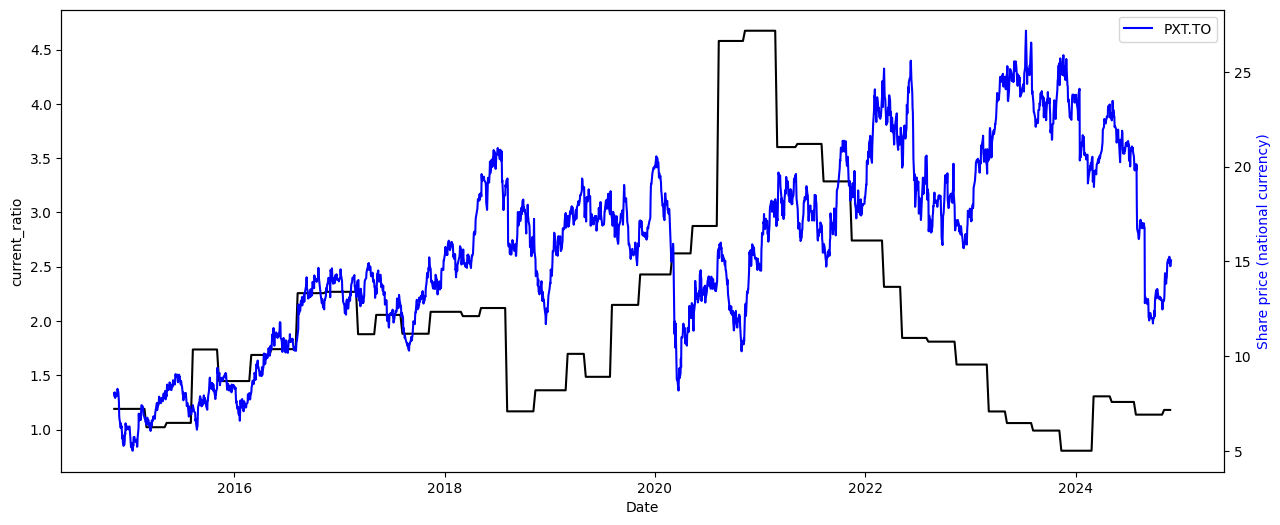

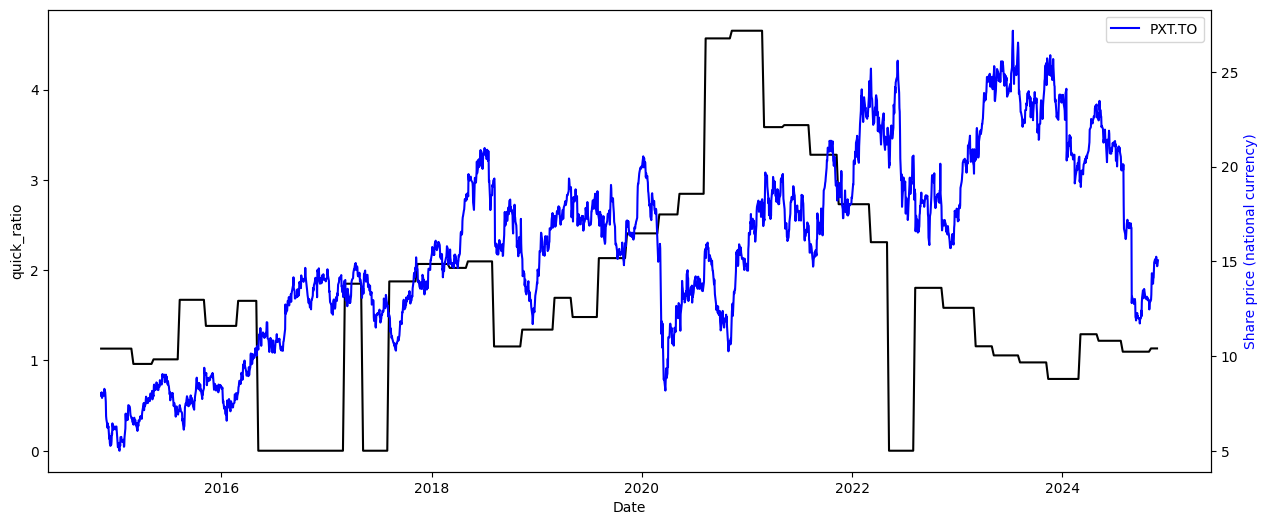

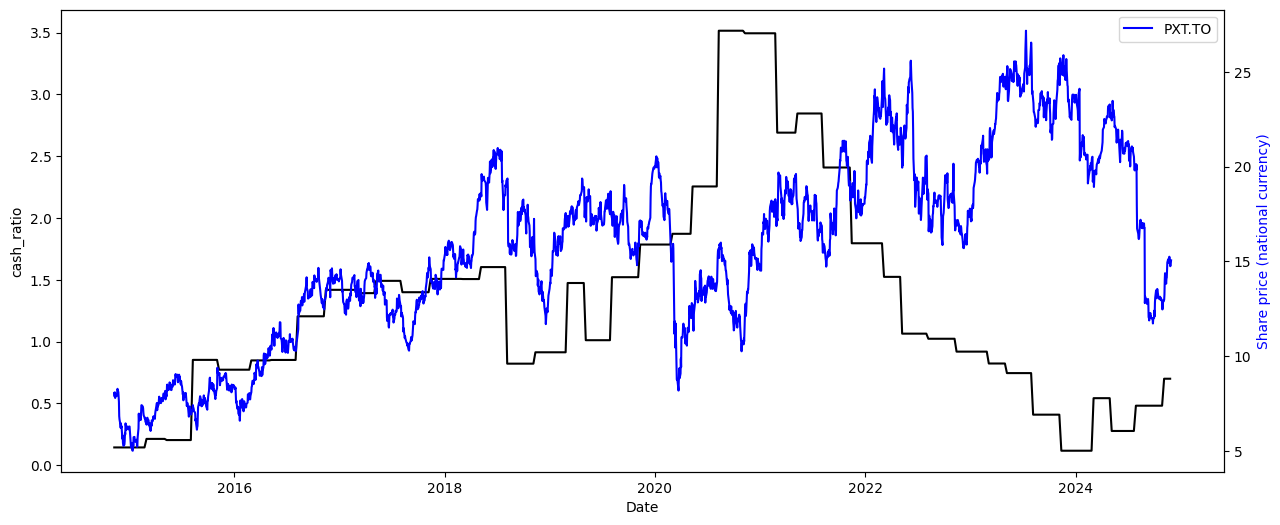

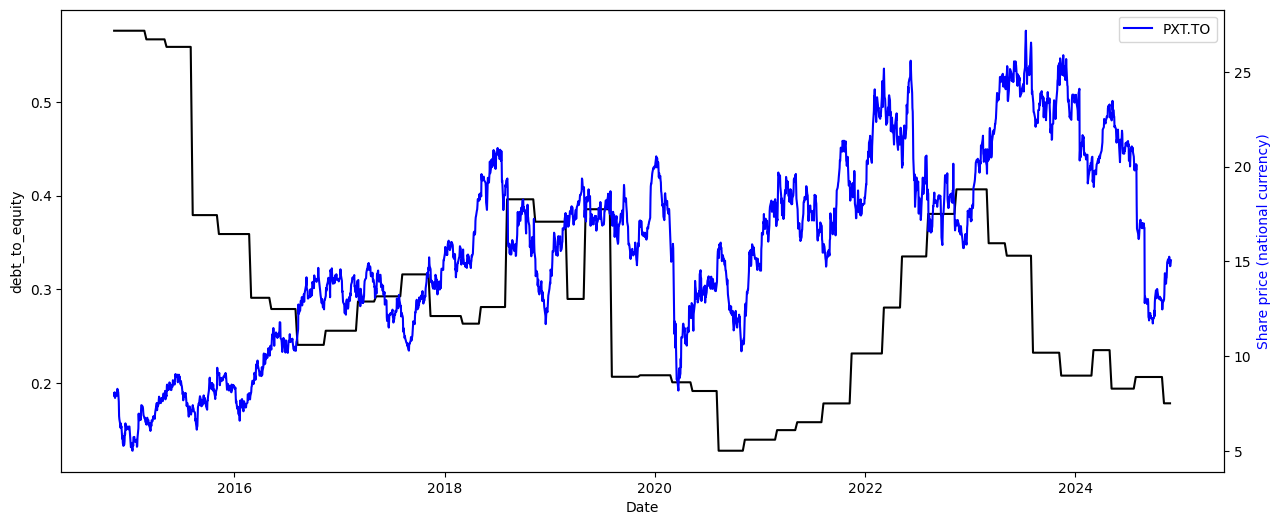

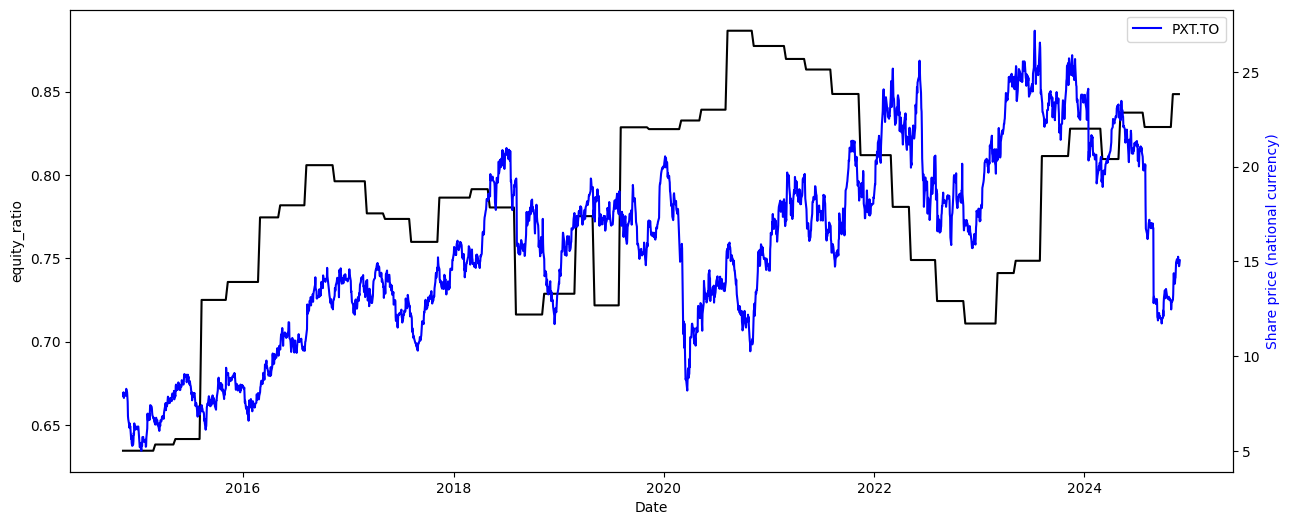

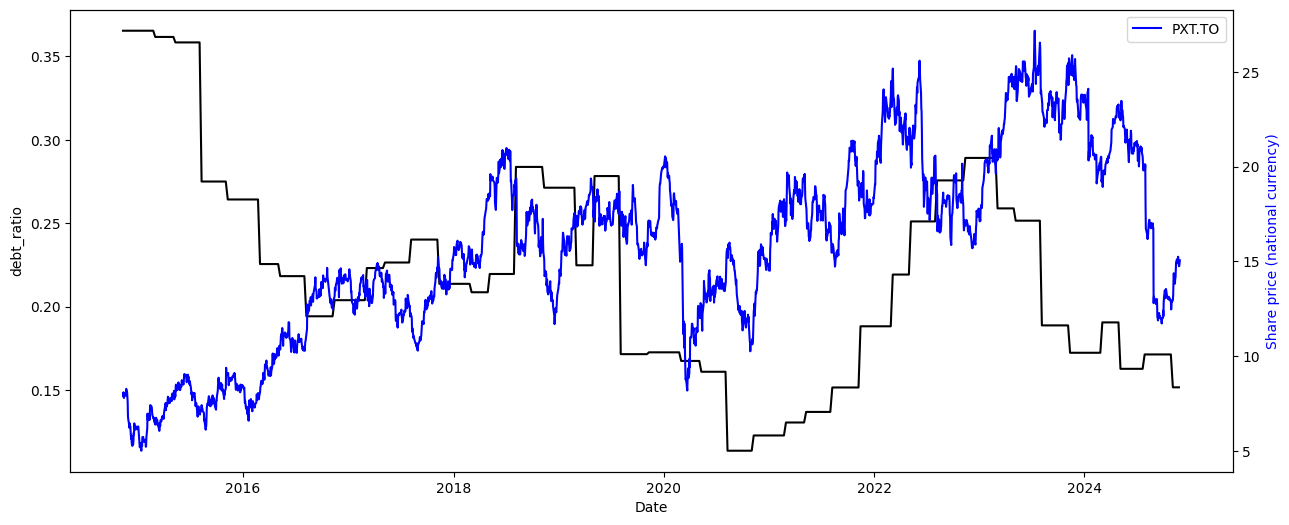

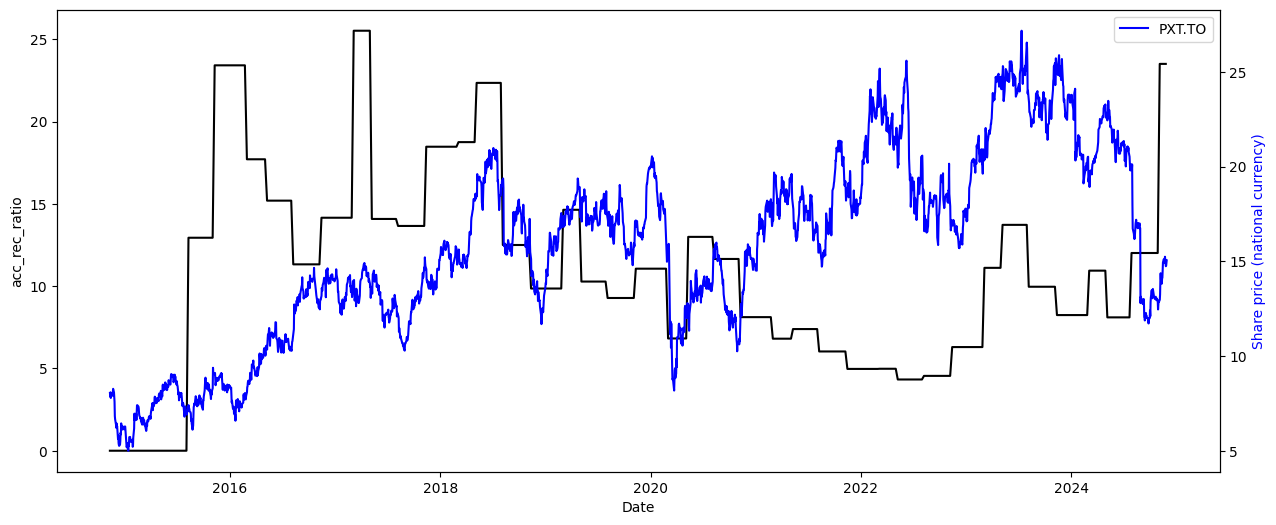

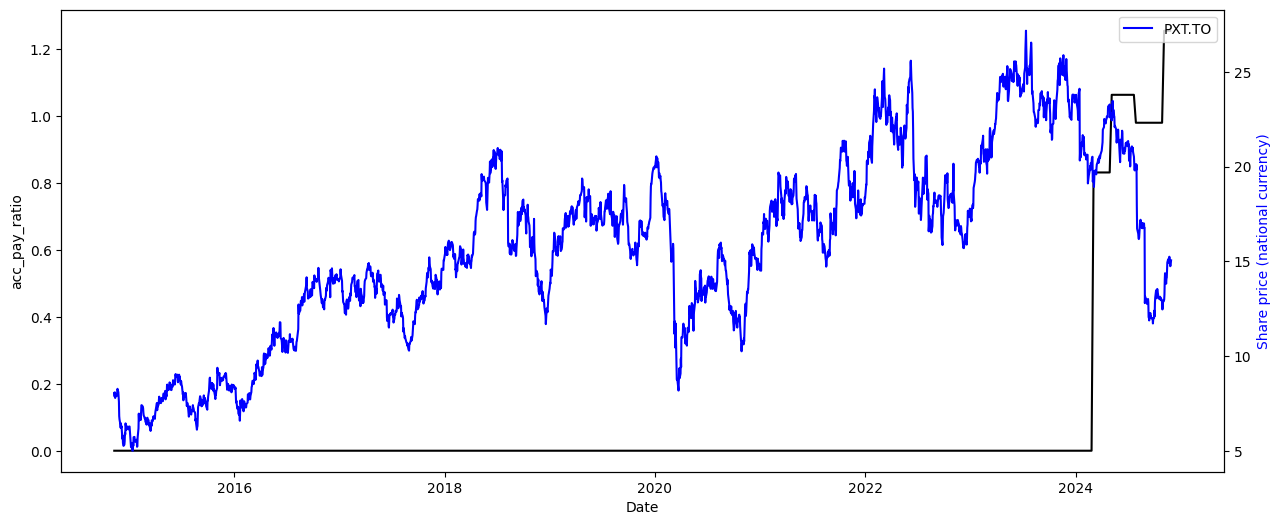

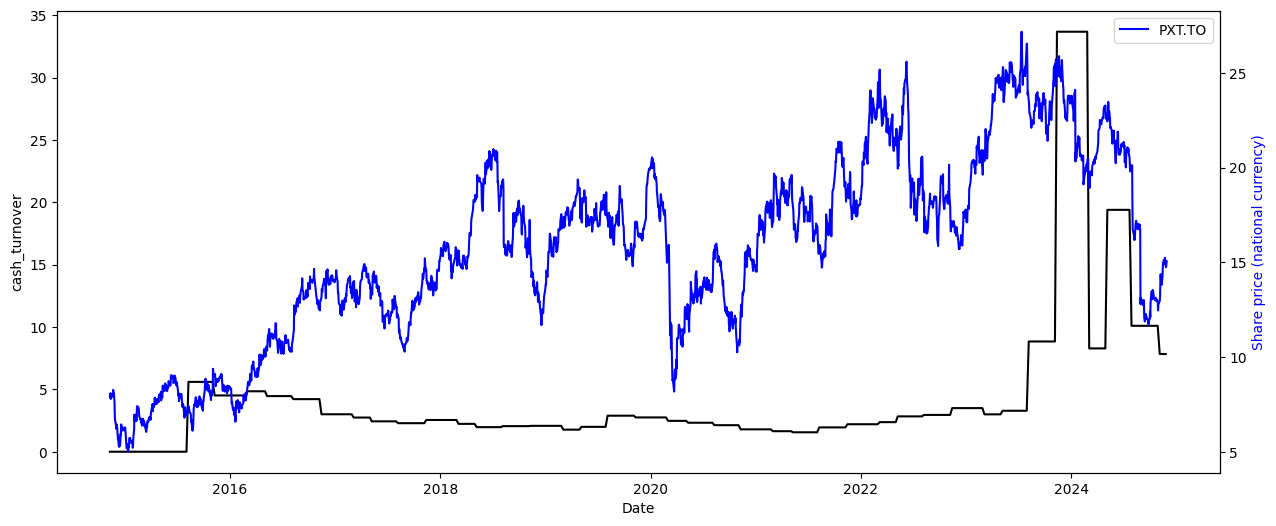

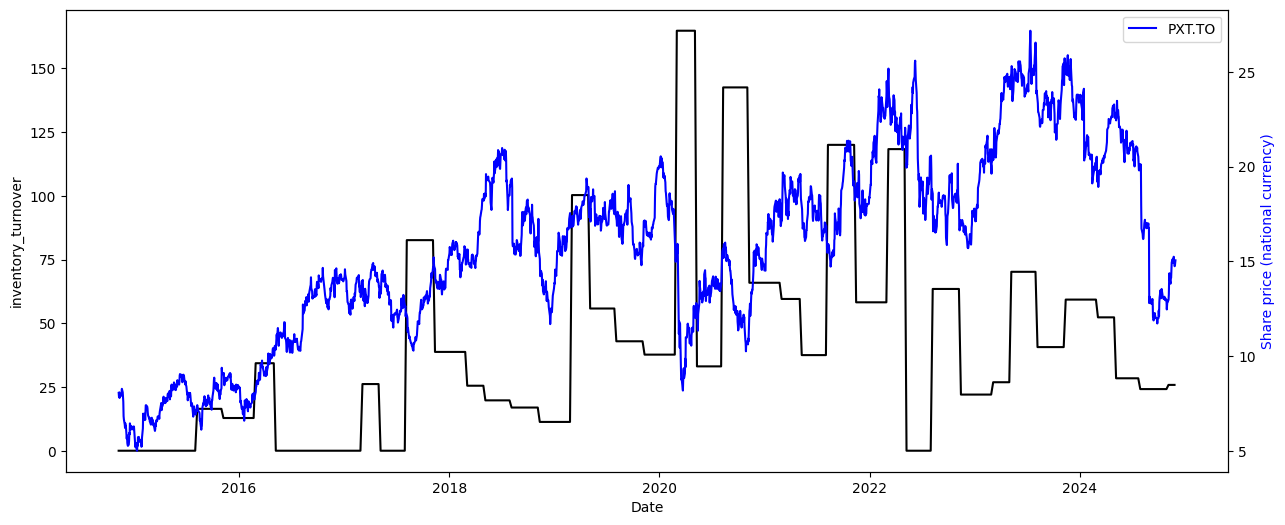

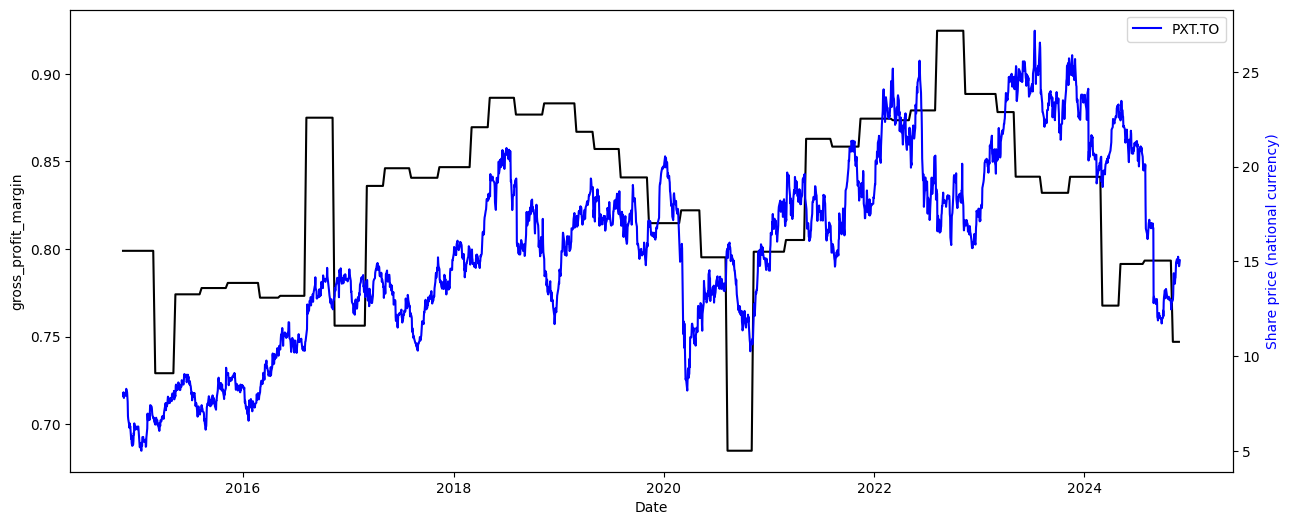

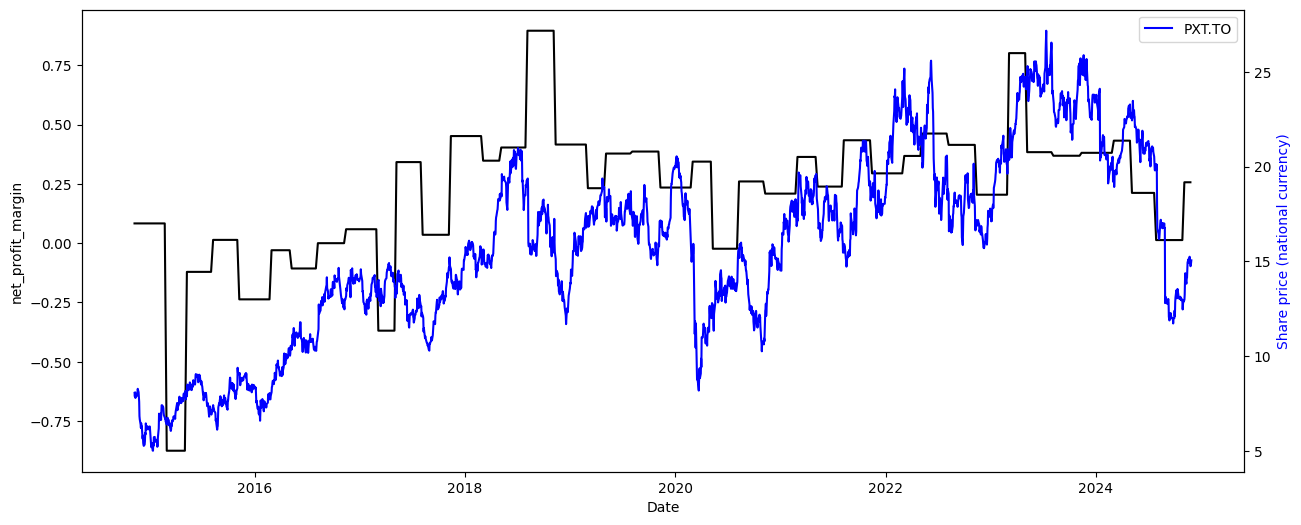

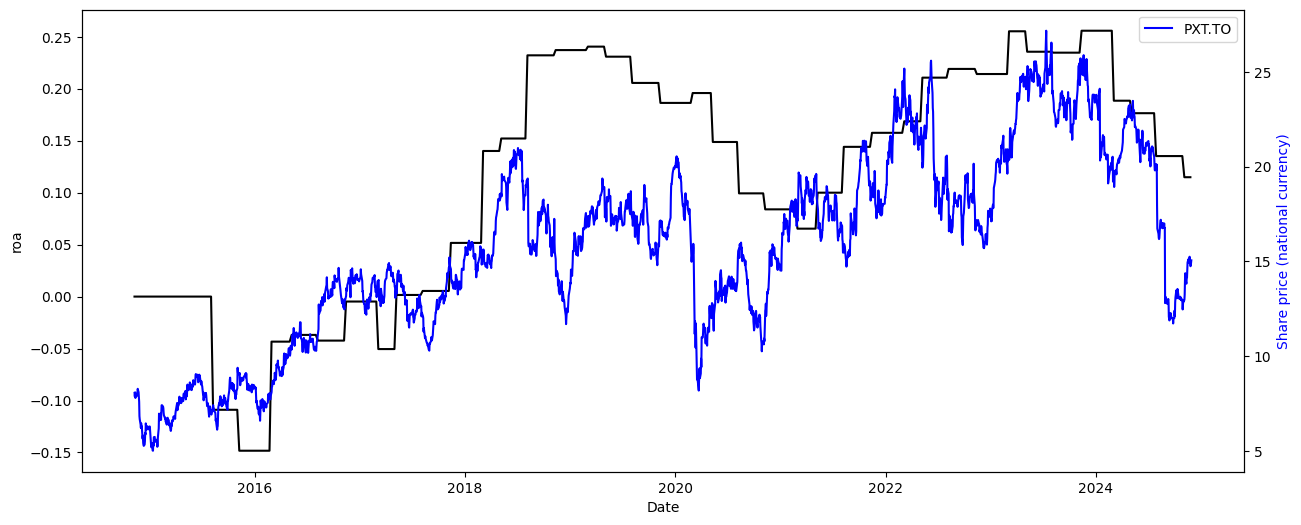

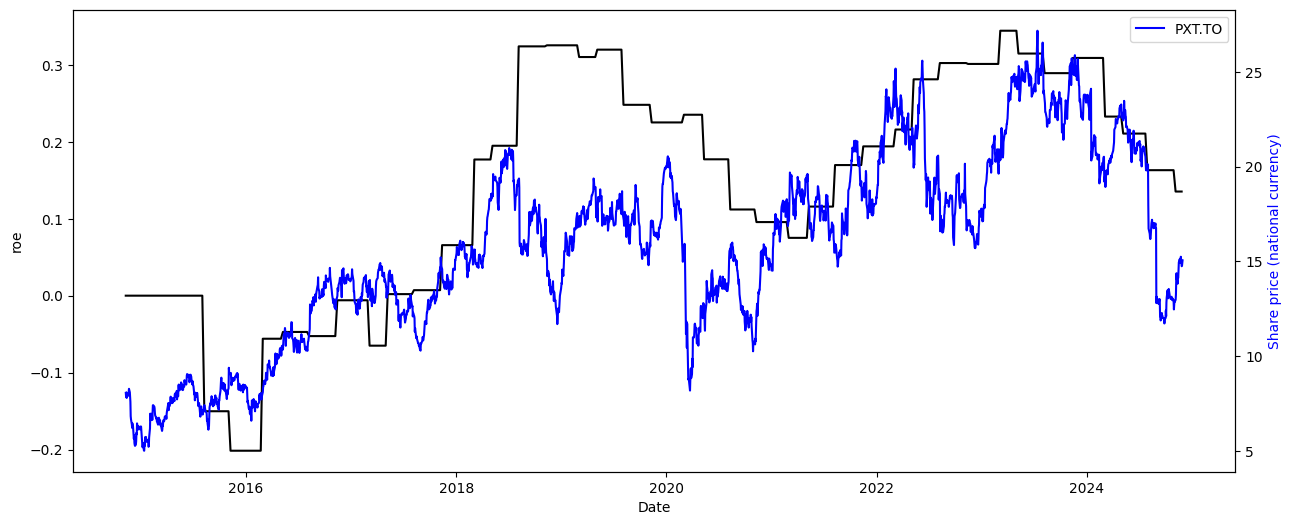

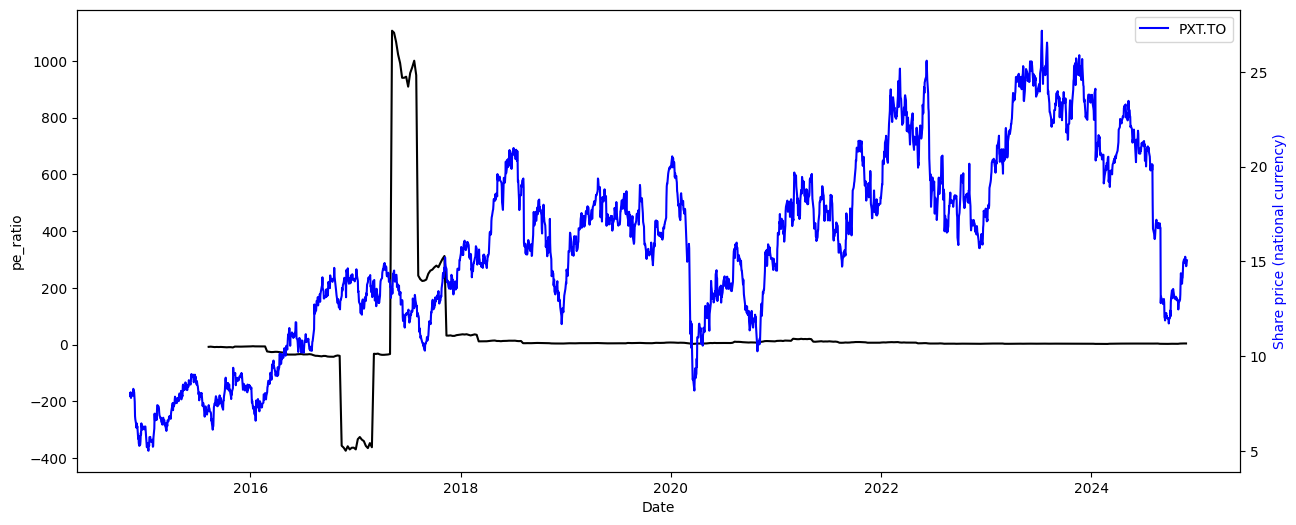

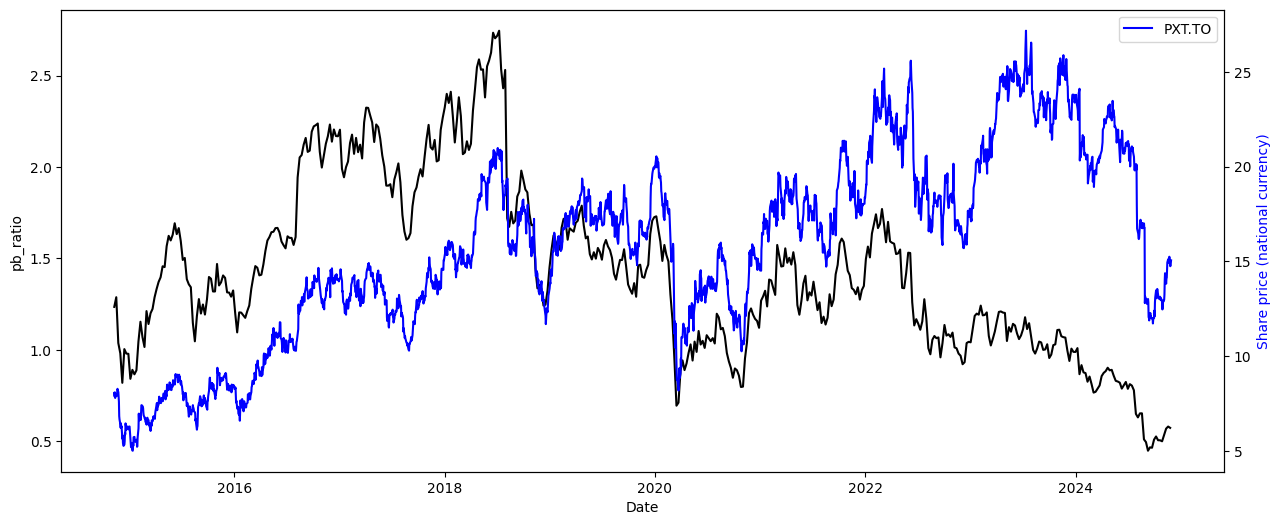

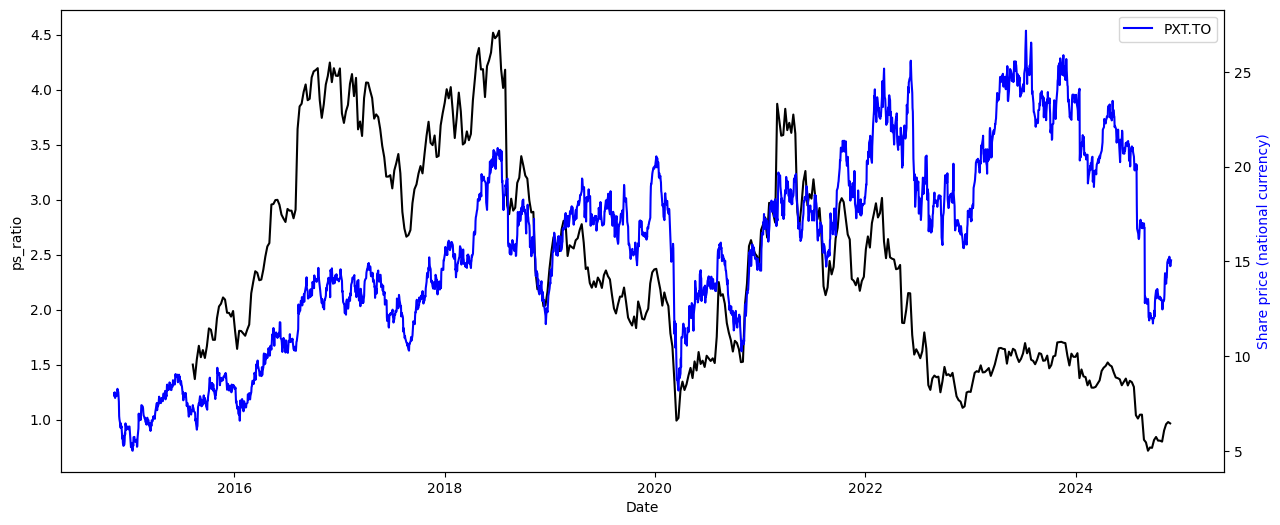

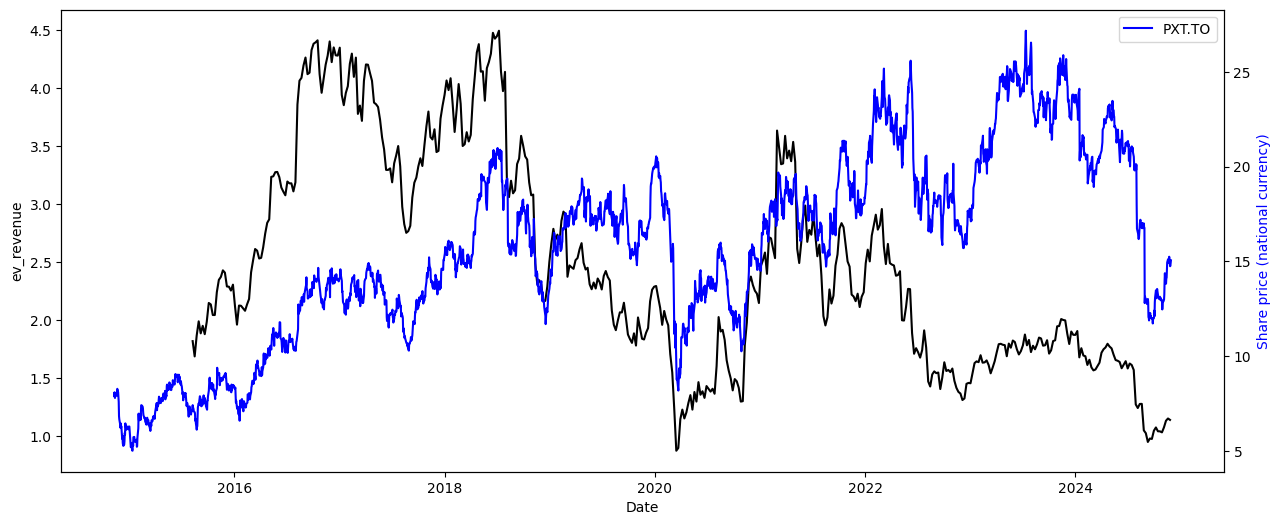

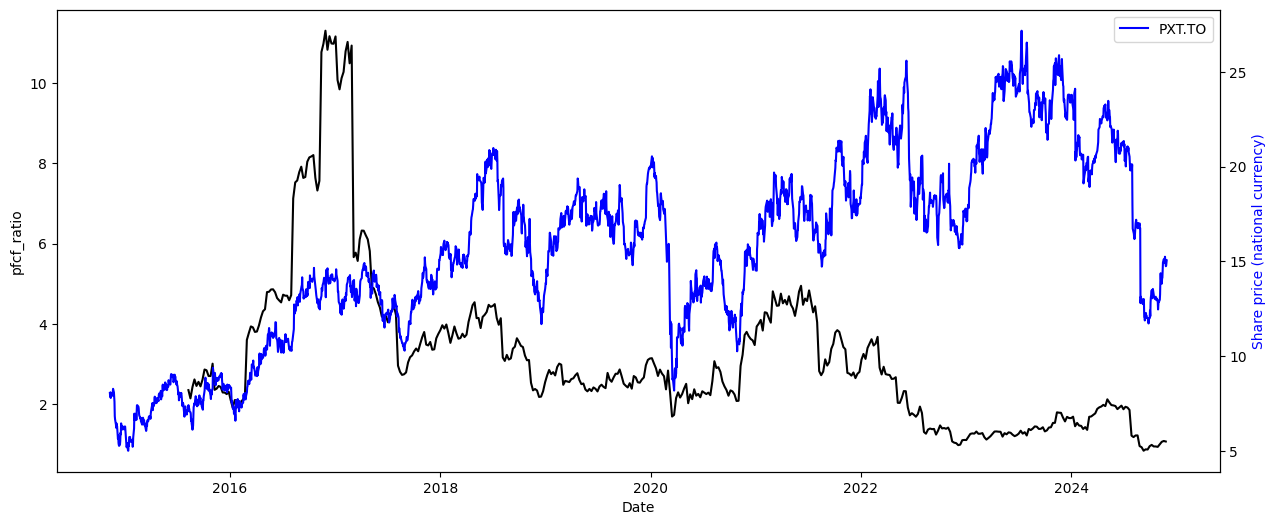

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

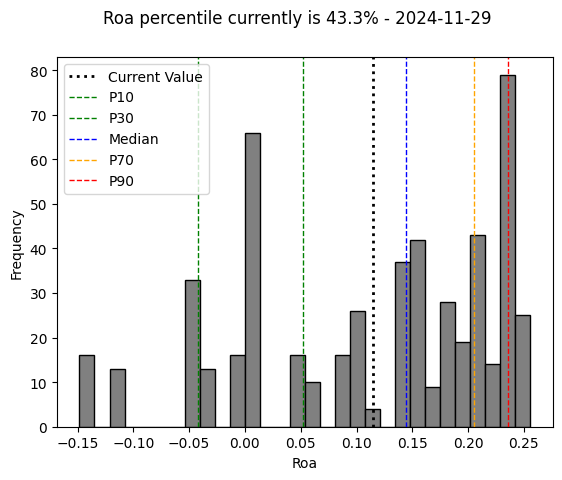

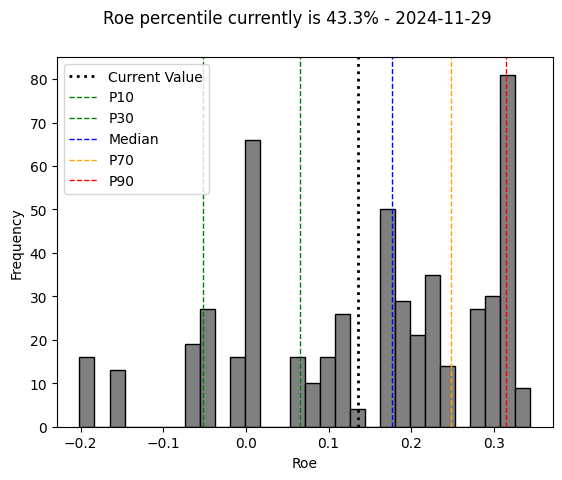

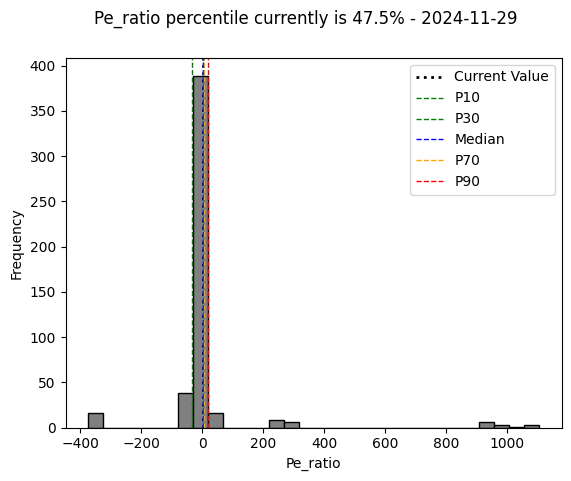

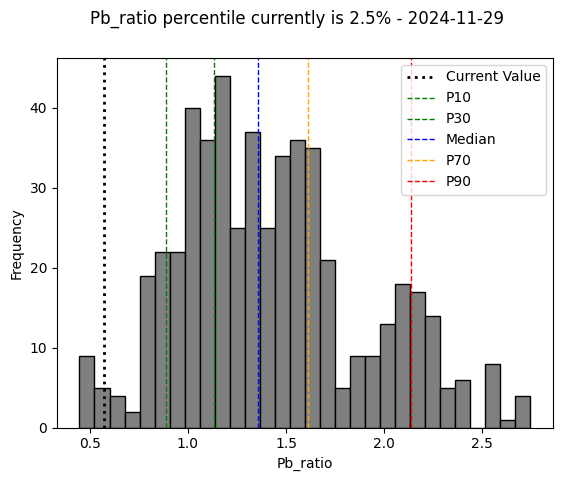

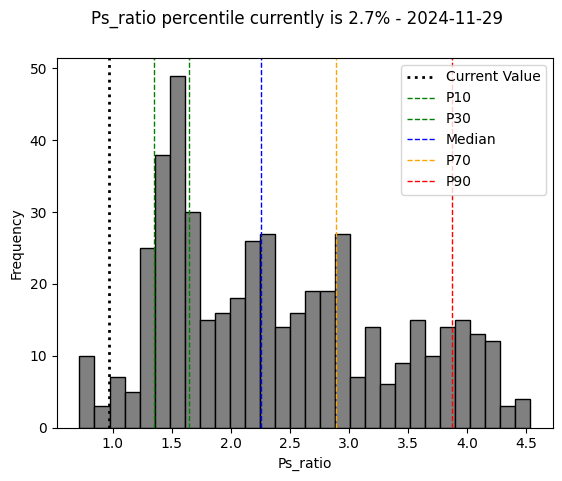

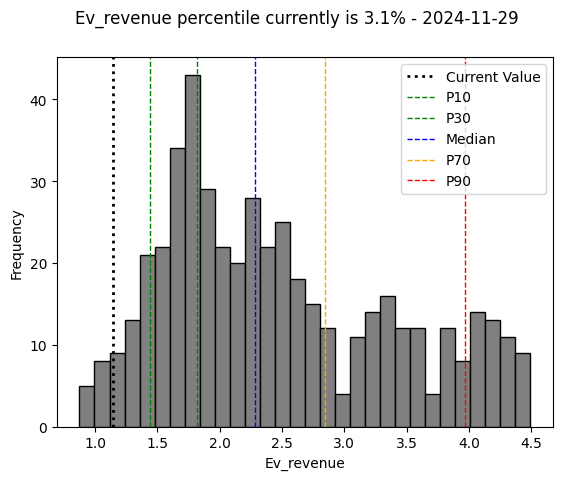

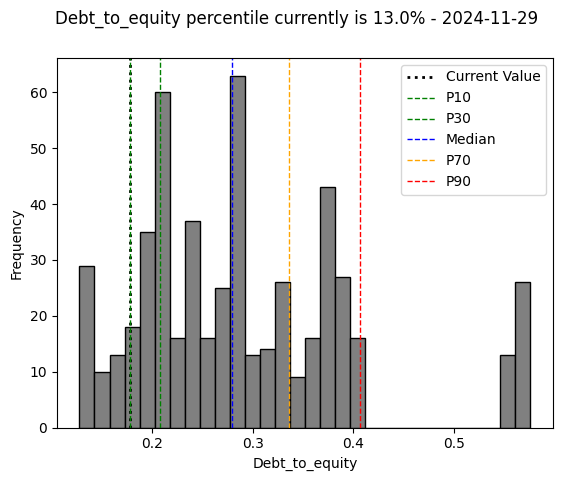

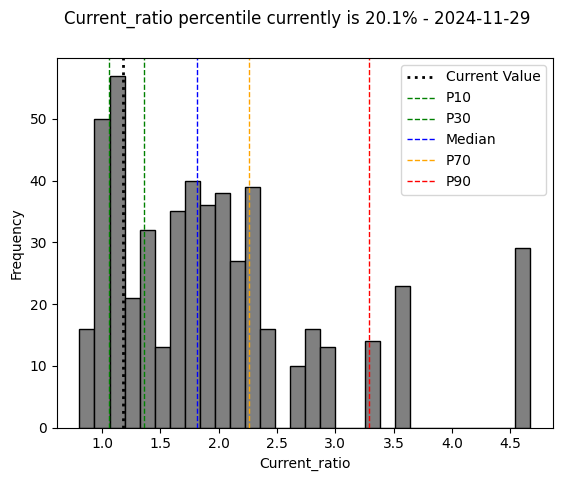

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.996401,-0.092197,-0.292272,-0.408914,-0.453333,-0.193621,-0.107704
roe,0.996401,1.000000,-0.088657,-0.266303,-0.389428,-0.427374,-0.136934,-0.137630
pe_ratio,-0.092197,-0.088657,1.000000,0.116284,0.072214,0.063649,0.067347,-0.007222
pb_ratio,-0.292272,-0.266303,0.116284,1.000000,0.932265,0.939138,0.056412,0.095615
ps_ratio,-0.408914,-0.389428,0.072214,0.932265,1.000000,0.982465,-0.044860,0.274573
ev_revenue,-0.453333,-0.427374,0.063649,0.939138,0.982465,1.000000,0.065639,0.118966
debt_to_equity,-0.193621,-0.136934,0.067347,0.056412,-0.044860,0.065639,1.000000,-0.614681
current_ratio,-0.107704,-0.137630,-0.007222,0.095615,0.274573,0.118966,-0.614681,1.000000


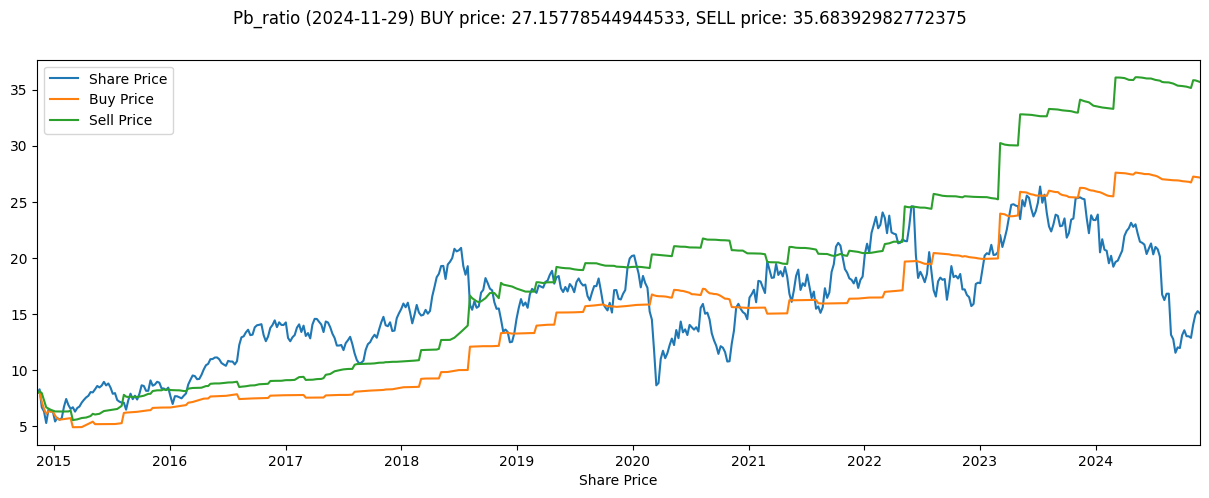

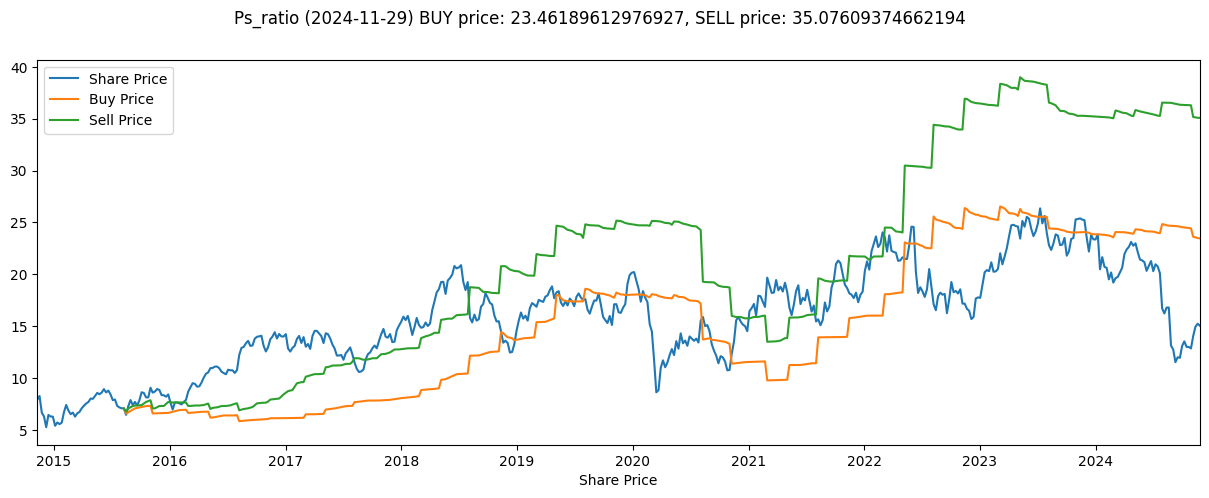

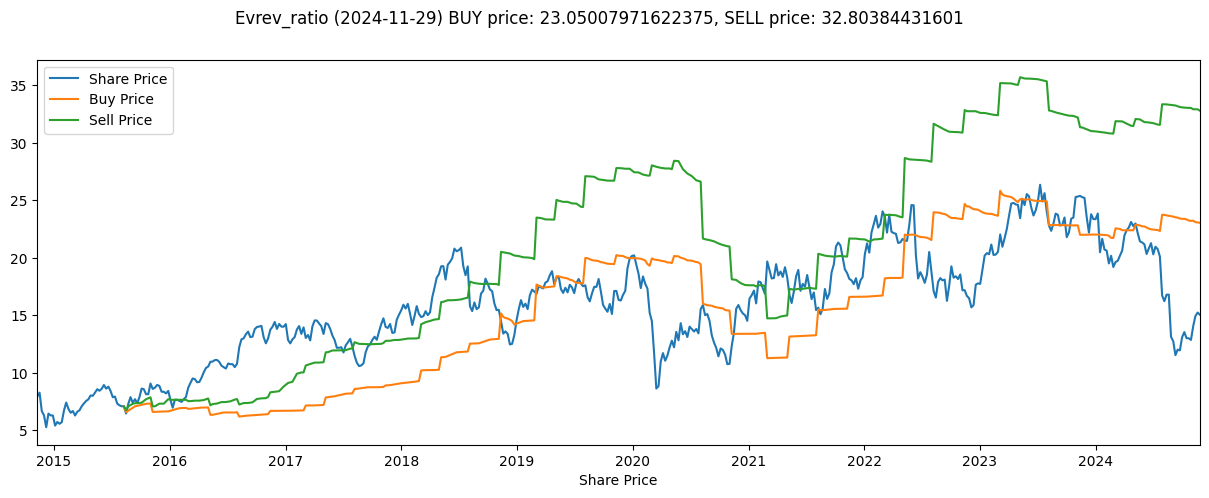

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)